# Detailed Investigation of DGE Skew

This notebook provides a more in-depth investigation into the observed DGE skew,
building upon the initial QC checks. We will examine:
1. Top highly expressed genes in Control vs. Mutant.
2. Percentage of ribosomal protein gene expression.
3. Expression of hemoglobin genes (potential contamination).
4. Potential batch effects.
5. Overall expression distributions.

In [1]:
# ## Environment Setup
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import anndata as ad
import warnings
from scipy.sparse import issparse

# Set plotting style
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = (6, 5) # Default figure size

# Ignore common warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ad.ImplicitModificationWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# ## Configuration
# --- User Configuration ---
TARGET_CLUSTER = 'HM' # <<< IMPORTANT: Verify this is a valid cluster name in 'mapmycells_second_layer'
TARGET_GENOTYPE = 'Nestin'
GROUPING_KEY = 'mapmycells_second_layer' # Column containing the cluster names
CONDITION_KEY = 'condition' # Column containing 'Control'/'Mutant'
GENOTYPE_KEY = 'genotype' # Column containing 'Emx1'/'Nestin'
MITO_PERCENT_KEY = 'percent_mt' # <<< IMPORTANT: Verify this is the correct column name for mitochondrial percentage
# List of potential batch keys to check in adata.obs
POTENTIAL_BATCH_KEYS = ['sample_id', 'batch', 'sequencing_run', 'library_prep_batch'] # Add more as needed
# --- End User Configuration ---

# Project Directories (adjust if needed)
# PROJECT_DIR = "/home/michal/Github/SRF_Linda_RNA" # Linux path
PROJECT_DIR = "D:/Github/SRF_Linda_RNA" # Windows path
WORKING_DIR = f"{PROJECT_DIR}/combine_data"
os.chdir(WORKING_DIR)
sys.path.insert(0, WORKING_DIR)

# Input AnnData file (output from script 16)
INPUT_DIR = f"{WORKING_DIR}/results_from_raw/final_annotation"
ADATA_FILENAME = 'merged_raw_final_annotated_simple_mapmycells_merged_GC.h5ad'
adata_path = os.path.join(INPUT_DIR, ADATA_FILENAME)

# Output directory for plots from this notebook
INVESTIGATION_PLOT_DIR_BASE = os.path.join(INPUT_DIR, f"investigation_plots_{TARGET_GENOTYPE}_{TARGET_CLUSTER}")
INVESTIGATION_PLOT_DIR_DETAILED = os.path.join(INPUT_DIR, f"investigation_plots_detailed_{TARGET_GENOTYPE}_{TARGET_CLUSTER}")
os.makedirs(INVESTIGATION_PLOT_DIR_DETAILED, exist_ok=True)

print(f"Project Directory: {PROJECT_DIR}")
print(f"Working Directory: {WORKING_DIR}")
print(f"Input AnnData Path: {adata_path}")
print(f"Base Investigation Plot Directory: {INVESTIGATION_PLOT_DIR_BASE}") # For summary.txt reference
print(f"Detailed Investigation Plot Directory: {INVESTIGATION_PLOT_DIR_DETAILED}")
print(f"Target Cluster ({GROUPING_KEY}): {TARGET_CLUSTER}")
print(f"Target Genotype ({GENOTYPE_KEY}): {TARGET_GENOTYPE}")

Project Directory: D:/Github/SRF_Linda_RNA
Working Directory: D:/Github/SRF_Linda_RNA/combine_data
Input AnnData Path: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\merged_raw_final_annotated_simple_mapmycells_merged_GC.h5ad
Base Investigation Plot Directory: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_Nestin_HM
Detailed Investigation Plot Directory: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_detailed_Nestin_HM
Target Cluster (mapmycells_second_layer): HM
Target Genotype (genotype): Nestin


In [3]:
# ## Load Data
print(f"Loading AnnData object from: {adata_path}")
if os.path.exists(adata_path):
    adata = sc.read_h5ad(adata_path)
    print("AnnData loaded successfully.")
    print(adata)
else:
    print(f"Error: AnnData file not found at {adata_path}")
    sys.exit(f"Exiting: AnnData file not found at {adata_path}")

# Display available metadata columns and layers
if adata:
    print("\nAvailable adata.obs columns:")
    print(list(adata.obs.columns))
    print("\nAvailable adata.layers:")
    print(list(adata.layers.keys()))
    print(f"\nChecking for '{GROUPING_KEY}' column...")
    if GROUPING_KEY not in adata.obs.columns:
        sys.exit(f"Error: Grouping key '{GROUPING_KEY}' not found in adata.obs!")
    else:
        print(f"'{GROUPING_KEY}' found. Unique values:")
        print(list(adata.obs[GROUPING_KEY].unique()))
        if TARGET_CLUSTER not in adata.obs[GROUPING_KEY].unique():
             print(f"Warning: Target cluster '{TARGET_CLUSTER}' not found in '{GROUPING_KEY}' column!")

    if GENOTYPE_KEY not in adata.obs.columns:
        sys.exit(f"Error: Genotype key '{GENOTYPE_KEY}' not found in adata.obs!")
    if CONDITION_KEY not in adata.obs.columns:
        sys.exit(f"Error: Condition key '{CONDITION_KEY}' not found in adata.obs!")
    if MITO_PERCENT_KEY and MITO_PERCENT_KEY not in adata.obs.columns:
        print(f"Warning: Mito percent key '{MITO_PERCENT_KEY}' not found. Mitochondrial plots might be affected.")
        # MITO_PERCENT_KEY = None # Optionally disable if strictly needed elsewhere

    if adata.raw is None and 'counts' not in adata.layers:
        print("\nWarning: adata.raw is None and 'counts' layer not found. Raw count based metrics might be unavailable.")

Loading AnnData object from: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\merged_raw_final_annotated_simple_mapmycells_merged_GC.h5ad
AnnData loaded successfully.
AnnData object with n_obs × n_vars = 23195 × 27611
    obs: 'sample', 'condition', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.8', 'leiden_0.8_alt', 'ISO_majority_voting', 'ISO_majority_voting_alt', 'ISO_conf_score', 'ISO_conf_score_alt', 'DG_majority_voting', 'DG_majority_voting_alt', 'DG_conf_score', 'DG_conf_score_alt', 'cell_type', 'mapmycells_first_layer', 'mapmycells_second_layer', 'genotype_condition'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'DG_majority_voting_colors', 'ISO_majority_voting_colors', 'cell_type_colors', 'condition_colors', 'genotype_colors', 'hvg', 'leiden_0.8', 

## Subset Data
Focus on the specific cluster and genotype of interest.

In [4]:
if adata and GROUPING_KEY in adata.obs.columns and GENOTYPE_KEY in adata.obs.columns:
    print(f"Subsetting data for {GROUPING_KEY} == '{TARGET_CLUSTER}' and {GENOTYPE_KEY} == '{TARGET_GENOTYPE}'...")
    cluster_mask = adata.obs[GROUPING_KEY] == TARGET_CLUSTER
    genotype_mask = adata.obs[GENOTYPE_KEY] == TARGET_GENOTYPE
    subset_mask = cluster_mask & genotype_mask
    adata_sub = adata[subset_mask].copy()

    print(f"\nSubset created with {adata_sub.n_obs} cells.")
    if adata_sub.n_obs > 0:
        print("Cell counts by condition in subset:")
        print(adata_sub.obs[CONDITION_KEY].value_counts())
        if not pd.api.types.is_categorical_dtype(adata_sub.obs[CONDITION_KEY]):
             adata_sub.obs[CONDITION_KEY] = adata_sub.obs[CONDITION_KEY].astype('category')
        if 'Control' in adata_sub.obs[CONDITION_KEY].cat.categories and 'Mutant' in adata_sub.obs[CONDITION_KEY].cat.categories:
             adata_sub.obs[CONDITION_KEY] = adata_sub.obs[CONDITION_KEY].cat.reorder_categories(['Control', 'Mutant'], ordered=True)
    else:
        sys.exit("Error: Subset is empty. Check TARGET_CLUSTER and TARGET_GENOTYPE.")
else:
    sys.exit("Skipping analysis due to missing data or keys for subsetting.")

# Determine layer for DGE-like analysis (normalized, log-transformed)
DGE_LAYER = None
if 'for_DEGs' in adata_sub.layers:
    DGE_LAYER = 'for_DEGs'
    print(f"Using layer '{DGE_LAYER}' for DGE-related analyses.")
elif adata_sub.X is not None: # Fallback to .X if 'for_DEGs' is not present
    DGE_LAYER = None # sc.pl functions use .X by default if layer is None
    print("Layer 'for_DEGs' not found. Using adata_sub.X for DGE-related analyses.")
else:
    print("Warning: Neither 'for_DEGs' layer nor adata_sub.X found. Some analyses might fail.")

# Determine layer for raw counts (for percentages like ribosomal, mito)
RAW_COUNT_LAYER_DATA = None
if adata_sub.raw is not None:
    RAW_COUNT_LAYER_DATA = adata_sub.raw.X
    adata_sub.obs['total_counts_raw'] = np.ravel(RAW_COUNT_LAYER_DATA.sum(axis=1))
    print("Using adata_sub.raw.X for raw count based calculations ('total_counts_raw' added to obs).")
elif 'counts' in adata_sub.layers: # Check for a 'counts' layer
    RAW_COUNT_LAYER_DATA = adata_sub.layers['counts']
    adata_sub.obs['total_counts_raw'] = np.ravel(RAW_COUNT_LAYER_DATA.sum(axis=1))
    print("Using adata_sub.layers['counts'] for raw count based calculations ('total_counts_raw' added to obs).")
else:
    print("Warning: No raw count data (adata_sub.raw or 'counts' layer) found. Raw count based metrics will be skipped or may be inaccurate if derived from processed layers.")
    # If 'total_counts_raw' was expected from the previous script's summary.txt, ensure it's present or recalculated.
    if 'total_counts_raw' not in adata_sub.obs.columns:
        print("   'total_counts_raw' not found in obs. Downstream raw count metrics will be affected.")

Subsetting data for mapmycells_second_layer == 'HM' and genotype == 'Nestin'...

Subset created with 899 cells.
Cell counts by condition in subset:
condition
Mutant     597
Control    302
Name: count, dtype: int64
Using layer 'for_DEGs' for DGE-related analyses.
Using adata_sub.raw.X for raw count based calculations ('total_counts_raw' added to obs).


## 1. Top Highly Expressed Genes Analysis
Compare the most abundant transcripts between Control and Mutant groups.


--- Analyzing Top Highly Expressed Genes ---

Top 30 genes in Control (HM - Nestin):
Malat1      4.855070
Plxdc2      3.993062
Csmd3       3.791737
Tanc2       3.676682
Nav3        3.649297
Elmo1       3.531921
Slc8a1      3.510181
Srgap2      3.411149
Qki         3.410750
Dock4       3.266552
Mef2a       3.240323
Tgfbr1      3.234941
Celf2       3.179228
Lsamp       3.162154
Mir99ahg    3.159750
Kcnip4      3.128989
Mef2c       3.127568
Hexb        3.104210
Pde3b       3.080720
Nav2        3.065532
Camk1d      3.050201
Epb41l2     3.048771
Zfhx3       3.044604
Mbnl1       3.008656
Ldlrad4     2.999038
Zeb2        2.936741
Ptprd       2.900853
Pcdh9       2.892791
Mertk       2.789425
Nrg3        2.788599
Name: mean_expr_Control, dtype: float32

Top 30 genes in Mutant (HM - Nestin):
Malat1      4.486289
Plxdc2      3.707073
Csmd3       3.431117
Nav3        3.400903
Tanc2       3.318786
Celf2       3.269251
Elmo1       3.238900
Kcnip4      3.236451
Lsamp       3.207924
Ptprd       3.19

<Figure size 600x500 with 0 Axes>

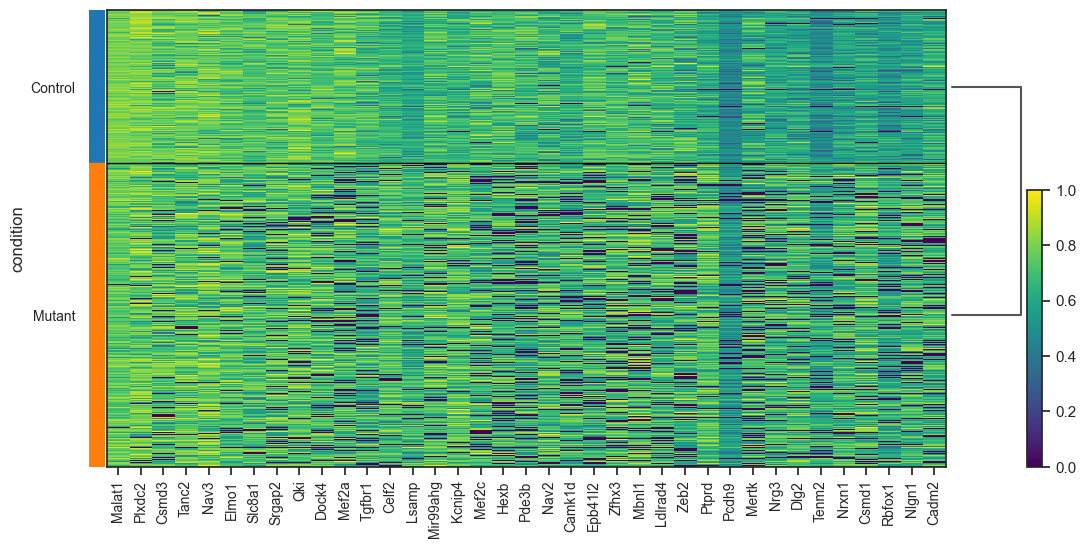

Saved heatmap: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_detailed_Nestin_HM\heatmap_top_genes_Nestin_HM.png


In [5]:
if adata_sub and DGE_LAYER is not None or adata_sub.X is not None:
    print("\n--- Analyzing Top Highly Expressed Genes ---")
    n_top_genes = 30

    # Calculate mean expression for each group using the DGE layer or .X
    mean_expr_dfs = []
    for condition_val in adata_sub.obs[CONDITION_KEY].cat.categories:
        adata_cond = adata_sub[adata_sub.obs[CONDITION_KEY] == condition_val]
        if DGE_LAYER:
            data_matrix = adata_cond.layers[DGE_LAYER]
        else:
            data_matrix = adata_cond.X

        if issparse(data_matrix):
            mean_expr = pd.Series(np.ravel(data_matrix.mean(axis=0)), index=adata_cond.var_names, name=f"mean_expr_{condition_val}")
        else:
            mean_expr = pd.Series(data_matrix.mean(axis=0), index=adata_cond.var_names, name=f"mean_expr_{condition_val}")
        mean_expr_dfs.append(mean_expr.sort_values(ascending=False).head(n_top_genes))

    if len(mean_expr_dfs) == 2:
        print(f"\nTop {n_top_genes} genes in Control ({TARGET_CLUSTER} - {TARGET_GENOTYPE}):")
        print(mean_expr_dfs[0])
        print(f"\nTop {n_top_genes} genes in Mutant ({TARGET_CLUSTER} - {TARGET_GENOTYPE}):")
        print(mean_expr_dfs[1])

        # Get union of top genes for heatmap
        union_top_genes = pd.concat([mean_expr_dfs[0], mean_expr_dfs[1]]).index.unique().tolist()
        print(f"\nPlotting heatmap for {len(union_top_genes)} unique top genes.")

        # Ensure genes are in adata_sub.var_names
        union_top_genes = [g for g in union_top_genes if g in adata_sub.var_names]

        if union_top_genes:
            plt.figure() # Ensure a new figure context for sc.pl
            sc.pl.heatmap(adata_sub, var_names=union_top_genes, groupby=CONDITION_KEY, layer=DGE_LAYER,
                          cmap='viridis', dendrogram=True, standard_scale='var', show=True)
            plt.suptitle(f"Top Expressed Genes Heatmap\n({TARGET_GENOTYPE} - {TARGET_CLUSTER})", y=1.05)
            output_path = os.path.join(INVESTIGATION_PLOT_DIR_DETAILED, f"heatmap_top_genes_{TARGET_GENOTYPE}_{TARGET_CLUSTER}.png")
            plt.savefig(output_path, dpi=150, bbox_inches='tight')
            print(f"Saved heatmap: {output_path}")
            plt.close()
        else:
            print("No common top genes found to plot heatmap.")
    else:
        print("Could not generate top gene lists for both conditions.")
else:
    print("Skipping top highly expressed genes analysis: DGE layer or .X not available or subset empty.")

## 2. Ribosomal Protein Gene Percentage
High or variable ribosomal content can sometimes indicate quality issues or specific biological states.

In [6]:
if adata_sub and RAW_COUNT_LAYER_DATA is not None:
    print("\n--- Analyzing Ribosomal Protein Gene Percentage ---")
    # Identify ribosomal genes (common prefixes for mouse/human)
    # Mitochondrial ribosomal proteins (Mrp) are often excluded unless specifically investigating mitochondria

    # Determine var_names corresponding to RAW_COUNT_LAYER_DATA
    if RAW_COUNT_LAYER_DATA is (adata_sub.raw.X if adata_sub.raw else None): # Check identity
        current_var_names = adata_sub.raw.var_names
        print(f"Deriving ribosomal mask from adata_sub.raw.var_names ({len(current_var_names)} genes)")
    elif 'counts' in adata_sub.layers and RAW_COUNT_LAYER_DATA is adata_sub.layers['counts']: # Check identity
        current_var_names = adata_sub.var_names # Assumes 'counts' layer uses adata_sub.var_names
        print(f"Deriving ribosomal mask from adata_sub.var_names ({len(current_var_names)} genes for 'counts' layer)")
    else:
        # Fallback or error, but RAW_COUNT_LAYER_DATA should be one of these if set
        print("Warning: Could not definitively determine var_names for RAW_COUNT_LAYER_DATA. Using adata_sub.var_names as a fallback.")
        current_var_names = adata_sub.var_names

    rp_gene_mask_for_raw_layer = current_var_names.str.contains(r'^(Rps|Rpl)[0-9]', case=False, regex=True)
    num_rp_genes = rp_gene_mask_for_raw_layer.sum()
    print(f"Found {num_rp_genes} ribosomal genes in the source for raw counts.")

    if num_rp_genes > 0:
        # Manual calculation
        # Ensure ribo_sum_per_cell is a dense array for division
        ribo_sum_per_cell = np.asarray(RAW_COUNT_LAYER_DATA[:, rp_gene_mask_for_raw_layer].sum(axis=1)).ravel()
        
        # Ensure 'total_counts_raw' is available and correctly calculated from RAW_COUNT_LAYER_DATA
        # Also ensure it's a dense array for division
        if 'total_counts_raw' not in adata_sub.obs or not np.allclose(np.asarray(adata_sub.obs['total_counts_raw'].values), np.asarray(RAW_COUNT_LAYER_DATA.sum(axis=1)).ravel()):
            print("Recalculating 'total_counts_raw' from RAW_COUNT_LAYER_DATA for consistency.")
            adata_sub.obs['total_counts_raw'] = np.asarray(RAW_COUNT_LAYER_DATA.sum(axis=1)).ravel()
        
        total_sum_per_cell = adata_sub.obs['total_counts_raw'].values # This is already a dense numpy array

        adata_sub.obs['pct_counts_ribosomal'] = np.divide(ribo_sum_per_cell, total_sum_per_cell,
                                                          out=np.zeros_like(ribo_sum_per_cell, dtype=float),
                                                          where=total_sum_per_cell != 0) * 100
        print("Calculated 'pct_counts_ribosomal' manually.")
        
        # Add 'ribosomal' to adata_sub.var for completeness if needed by other parts, though not used by this manual calc directly for indexing RAW_COUNT_LAYER_DATA
        # This definition is based on adata_sub.var_names, so it's for the subsetted view.
        adata_sub.var['ribosomal'] = adata_sub.var_names.str.contains(r'^(Rps|Rpl)[0-9]', case=False, regex=True)


        if 'pct_counts_ribosomal' in adata_sub.obs.columns:
            plt.figure(figsize=(5, 4))
            sns.violinplot(data=adata_sub.obs, x=CONDITION_KEY, y='pct_counts_ribosomal', inner='quartile', cut=0)
            sns.stripplot(data=adata_sub.obs, x=CONDITION_KEY, y='pct_counts_ribosomal', color='black', size=2, alpha=0.3)
            plt.title(f"Ribosomal Gene Percentage\n({TARGET_GENOTYPE} - {TARGET_CLUSTER})")
            plt.xlabel("Condition")
            plt.ylabel("% Ribosomal Counts")
            sns.despine()
            plt.tight_layout()
            output_path = os.path.join(INVESTIGATION_PLOT_DIR_DETAILED, f"qc_ribo_percent_{TARGET_GENOTYPE}_{TARGET_CLUSTER}.png")
            plt.savefig(output_path, dpi=150)
            print(f"Saved plot: {output_path}")
            plt.close()

            # Add to summary statistics if possible (re-run original summary or append)
            print("Ribosomal percentage stats:")
            print(adata_sub.obs.groupby(CONDITION_KEY)['pct_counts_ribosomal'].describe())
        else:
            print("Could not calculate 'pct_counts_ribosomal'.")
    else:
        print("No ribosomal genes found with the specified pattern.")
else:
    print("Skipping ribosomal gene percentage: Raw count data not available or subset empty.")


--- Analyzing Ribosomal Protein Gene Percentage ---
Deriving ribosomal mask from adata_sub.raw.var_names (33685 genes)
Found 96 ribosomal genes in the source for raw counts.
Calculated 'pct_counts_ribosomal' manually.
Saved plot: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_detailed_Nestin_HM\qc_ribo_percent_Nestin_HM.png
Ribosomal percentage stats:
           count      mean       std       min       25%       50%       75%  \
condition                                                                      
Control    302.0  0.661431  0.270022  0.226501  0.486101  0.615155  0.781137   
Mutant     597.0  0.487938  0.284740  0.000000  0.283607  0.447761  0.644330   

                max  
condition            
Control    1.715551  
Mutant     1.750292  


## 3. Hemoglobin Gene Expression
Check for hemoglobin genes, which can indicate blood contamination if not expected.


--- Analyzing Hemoglobin Gene Expression ---
Found 5 potential hemoglobin genes: ['Hbb-bt', 'Hbb-bs', 'Hba-x', 'Hba-a1', 'Hba-a2']

Hemoglobin Gene Expression Statistics:
Analyzing across 2 conditions: Mutant, Control

Statistics for Hbb-bt:
  Overall (n=899): mean=0.0023, median=0.0000, std=0.0677
  Expressed in 1/899 cells (0.1%)
  Mutant (n=597): mean=0.0034, median=0.0000, std=0.0831
    Expressed in 1/597 cells (0.2%)
  Control (n=302): mean=0.0000, median=0.0000, std=0.0000
    Expressed in 0/302 cells (0.0%)
  Statistical comparison:
    Mann-Whitney U test: statistic=90298.0000, p-value=0.478396
    No significant difference detected (p >= 0.05)

Statistics for Hbb-bs:
  Overall (n=899): mean=0.0167, median=0.0000, std=0.1845
  Expressed in 8/899 cells (0.9%)
  Mutant (n=597): mean=0.0189, median=0.0000, std=0.2086
    Expressed in 5/597 cells (0.8%)
  Control (n=302): mean=0.0123, median=0.0000, std=0.1236
    Expressed in 3/302 cells (1.0%)
  Statistical comparison:
    Mann

<Figure size 600x500 with 0 Axes>

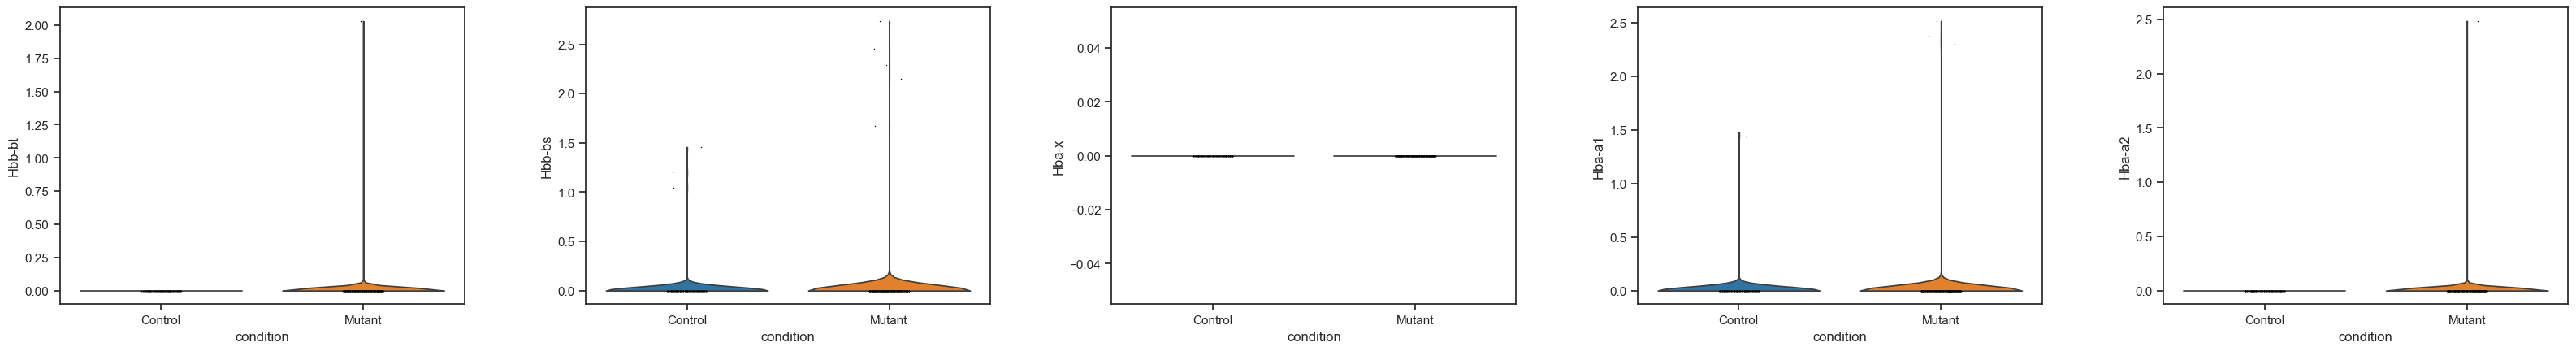

Saved plot: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_detailed_Nestin_HM\expr_hemoglobin_Nestin_HM.png


In [14]:
if adata_sub:
    print("\n--- Analyzing Hemoglobin Gene Expression ---")
    # Common hemoglobin gene prefixes for mouse
    hb_genes_patterns = [r'^Hba-', r'^Hbb-', r'^Hbg-', r'^Hbe-', r'^Hbz-']
    # Use np.full for boolean array initialization to avoid DeprecationWarning
    hb_gene_mask = np.full(adata_sub.n_vars, False, dtype=bool)
    for pattern in hb_genes_patterns:
        hb_gene_mask |= adata_sub.var_names.str.contains(pattern, case=False, regex=True)
    
    actual_hb_genes = adata_sub.var_names[hb_gene_mask].tolist()
    print(f"Found {len(actual_hb_genes)} potential hemoglobin genes: {actual_hb_genes}")

    if actual_hb_genes:
        # Calculate and print statistical summaries for hemoglobin genes
        print("\nHemoglobin Gene Expression Statistics:")
        
        # Get condition groups
        conditions = adata_sub.obs[CONDITION_KEY].unique()
        print(f"Analyzing across {len(conditions)} conditions: {', '.join(conditions)}")
        
        # Calculate statistics per gene and condition
        for gene in actual_hb_genes:
            print(f"\nStatistics for {gene}:")
            
            # Get expression data for this gene (for all cells)
            gene_idx = adata_sub.var_names.get_loc(gene)
            
            # Get expression data in the appropriate layer
            if DGE_LAYER in adata_sub.layers:
                gene_expr = adata_sub.layers[DGE_LAYER][:, gene_idx]
            else:
                gene_expr = adata_sub.X[:, gene_idx]
                
            # Convert to dense array if sparse
            if scipy.sparse.issparse(gene_expr):
                gene_expr = gene_expr.toarray().flatten()
            
            # Calculate overall statistics
            overall_mean = np.mean(gene_expr)
            overall_median = np.median(gene_expr)
            overall_std = np.std(gene_expr)
            overall_nonzero = np.sum(gene_expr > 0)
            overall_pct_expressed = (overall_nonzero / len(gene_expr)) * 100
            
            print(f"  Overall (n={len(gene_expr)}): mean={overall_mean:.4f}, median={overall_median:.4f}, std={overall_std:.4f}")
            print(f"  Expressed in {overall_nonzero}/{len(gene_expr)} cells ({overall_pct_expressed:.1f}%)")
            
            # Calculate per-condition statistics
            condition_data = {}  # Store data for statistical testing
            
            for condition in conditions:
                # Get indices where condition matches
                condition_indices = np.where(adata_sub.obs[CONDITION_KEY] == condition)[0]
                
                # Extract expression data for these indices
                if DGE_LAYER in adata_sub.layers:
                    condition_expr = adata_sub.layers[DGE_LAYER][condition_indices, gene_idx]
                else:
                    condition_expr = adata_sub.X[condition_indices, gene_idx]
                
                # Convert to dense array if sparse
                if scipy.sparse.issparse(condition_expr):
                    condition_expr = condition_expr.toarray().flatten()
                
                # Store for statistical testing
                condition_data[condition] = condition_expr
                
                # Calculate statistics
                cond_mean = np.mean(condition_expr)
                cond_median = np.median(condition_expr)
                cond_std = np.std(condition_expr)
                cond_count = len(condition_expr)
                cond_nonzero = np.sum(condition_expr > 0)
                cond_pct_expressed = (cond_nonzero / cond_count) * 100
                
                print(f"  {condition} (n={cond_count}): mean={cond_mean:.4f}, median={cond_median:.4f}, std={cond_std:.4f}")
                print(f"    Expressed in {cond_nonzero}/{cond_count} cells ({cond_pct_expressed:.1f}%)")
            
            # Run a statistical test to compare conditions if more than one condition exists
            if len(conditions) > 1:
                print("  Statistical comparison:")
                
                # Run Mann-Whitney U test for two conditions or Kruskal-Wallis for more
                if len(conditions) == 2:
                    cond_list = list(conditions)
                    stat, pval = scipy.stats.mannwhitneyu(
                        condition_data[cond_list[0]], 
                        condition_data[cond_list[1]], 
                        alternative='two-sided'
                    )
                    test_name = "Mann-Whitney U test"
                else:
                    stat, pval = scipy.stats.kruskal(*condition_data.values())
                    test_name = "Kruskal-Wallis H test"
                
                print(f"    {test_name}: statistic={stat:.4f}, p-value={pval:.6f}")
                if pval < 0.05:
                    print(f"    Significant difference detected (p < 0.05)")
                else:
                    print(f"    No significant difference detected (p >= 0.05)")

        # Generate fold change statistics if there are exactly 2 conditions
        if len(conditions) == 2:
            cond_list = list(conditions)
            print(f"\nFold Change Analysis ({cond_list[0]} vs {cond_list[1]}):")
            
            for gene in actual_hb_genes:
                gene_idx = adata_sub.var_names.get_loc(gene)
                
                # Get expression data for each condition
                condition_means = {}
                for condition in cond_list:
                    condition_indices = np.where(adata_sub.obs[CONDITION_KEY] == condition)[0]
                    
                    if DGE_LAYER in adata_sub.layers:
                        condition_expr = adata_sub.layers[DGE_LAYER][condition_indices, gene_idx]
                    else:
                        condition_expr = adata_sub.X[condition_indices, gene_idx]
                    
                    if scipy.sparse.issparse(condition_expr):
                        condition_expr = condition_expr.toarray().flatten()
                    
                    condition_means[condition] = np.mean(condition_expr)
                
                # Calculate fold change
                if condition_means[cond_list[1]] > 0 and condition_means[cond_list[0]] > 0:
                    fold_change = condition_means[cond_list[0]] / condition_means[cond_list[1]]
                    log2_fold_change = np.log2(fold_change)
                    
                    print(f"  {gene}: {cond_list[0]}/{cond_list[1]} = {fold_change:.4f} (log2FC: {log2_fold_change:.4f})")
                else:
                    print(f"  {gene}: Fold change calculation skipped (zero mean expression in one or both conditions)")
                
        plt.figure()
        sc.pl.violin(adata_sub, keys=actual_hb_genes, groupby=CONDITION_KEY, layer=DGE_LAYER,
                      stripplot=True, multi_panel=True, show=True, cut=0, use_raw=False) # use_raw=False as DGE_LAYER is specified or .X is used
        plt.suptitle(f"Hemoglobin Gene Expression\n({TARGET_GENOTYPE} - {TARGET_CLUSTER})", y=1.02)
        output_path = os.path.join(INVESTIGATION_PLOT_DIR_DETAILED, f"expr_hemoglobin_{TARGET_GENOTYPE}_{TARGET_CLUSTER}.png")
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot: {output_path}")
        plt.close()
    else:
        print("No hemoglobin genes found with the specified patterns.")
else:
    print("Skipping hemoglobin gene analysis: Subset empty.")

## 5. Overall Expression Distributions
Plot density of average gene expressions and total counts per cell.


--- Analyzing Overall Expression Distributions ---
Saved plot: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_detailed_Nestin_HM\dist_mean_gene_expr_Nestin_HM.png


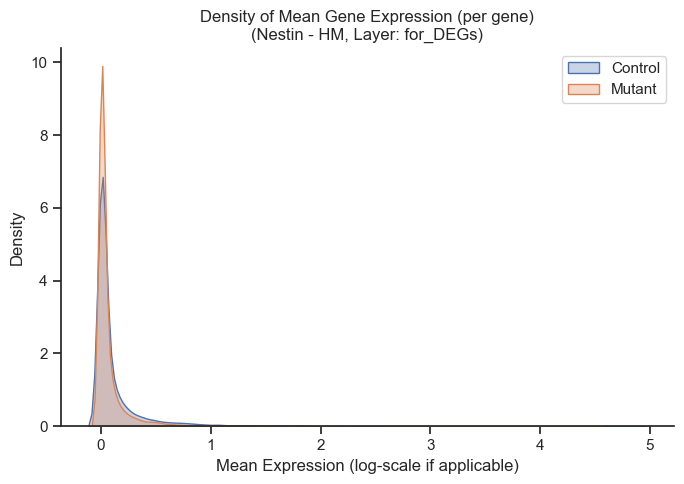

Saved plot: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_detailed_Nestin_HM\dist_total_counts_raw_Nestin_HM.png


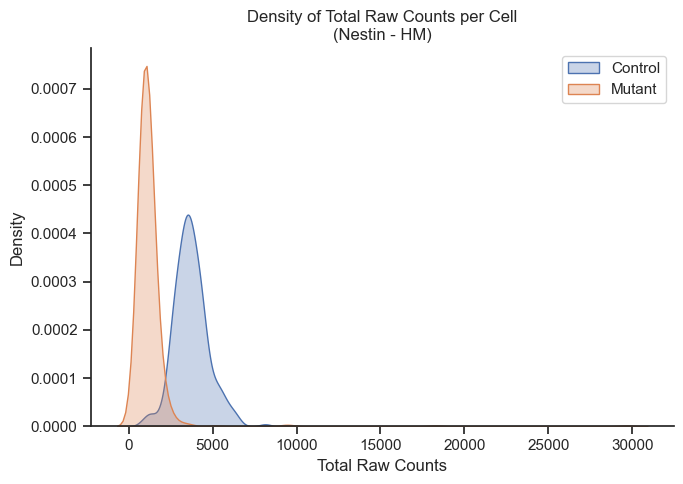

Saved plot: D:/Github/SRF_Linda_RNA/combine_data/results_from_raw/final_annotation\investigation_plots_detailed_Nestin_HM\dist_sum_expr_dge_layer_Nestin_HM.png


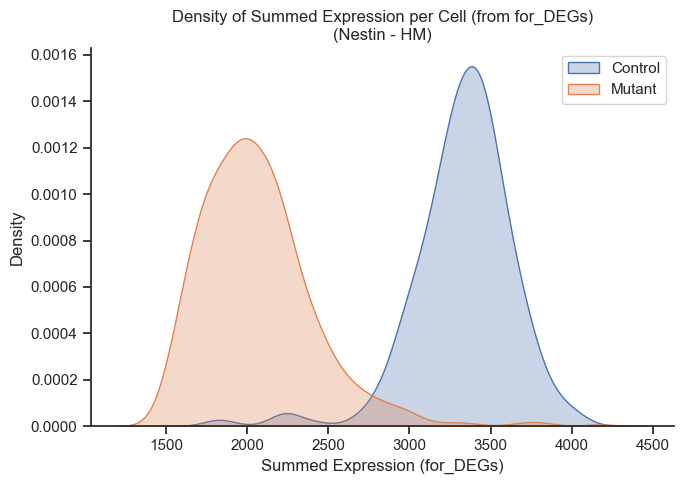

In [11]:
if adata_sub:
    print("\n--- Analyzing Overall Expression Distributions ---")

    # 1. Density of average gene expression (using DGE layer or .X)
    plt.figure(figsize=(7, 5))
    for condition_val in adata_sub.obs[CONDITION_KEY].cat.categories:
        adata_cond = adata_sub[adata_sub.obs[CONDITION_KEY] == condition_val]
        if DGE_LAYER:
            data_matrix = adata_cond.layers[DGE_LAYER]
        else:
            data_matrix = adata_cond.X
        
        # Ensure mean_gene_expr is dense for kdeplot
        if issparse(data_matrix):
            mean_gene_expr = np.asarray(data_matrix.mean(axis=0)).ravel()
        else:
            mean_gene_expr = data_matrix.mean(axis=0) # Already dense
        
        sns.kdeplot(mean_gene_expr, label=condition_val, fill=True, alpha=0.3)
    plt.title(f"Density of Mean Gene Expression (per gene)\n({TARGET_GENOTYPE} - {TARGET_CLUSTER}, Layer: {DGE_LAYER if DGE_LAYER else '.X'})")
    plt.xlabel("Mean Expression (log-scale if applicable)")
    plt.ylabel("Density")
    plt.legend()
    sns.despine()
    plt.tight_layout()
    output_path = os.path.join(INVESTIGATION_PLOT_DIR_DETAILED, f"dist_mean_gene_expr_{TARGET_GENOTYPE}_{TARGET_CLUSTER}.png")
    plt.savefig(output_path, dpi=150)
    print(f"Saved plot: {output_path}")
    plt.show()
    plt.close()

    # 2. Density of total counts per cell (Raw)
    if 'total_counts_raw' in adata_sub.obs.columns:
        plt.figure(figsize=(7, 5))
        for condition_val in adata_sub.obs[CONDITION_KEY].cat.categories:
            sns.kdeplot(adata_sub.obs.loc[adata_sub.obs[CONDITION_KEY] == condition_val, 'total_counts_raw'],
                        label=condition_val, fill=True, alpha=0.3)
        plt.title(f"Density of Total Raw Counts per Cell\n({TARGET_GENOTYPE} - {TARGET_CLUSTER})")
        plt.xlabel("Total Raw Counts")
        plt.ylabel("Density")
        plt.legend()
        sns.despine()
        plt.tight_layout()
        output_path = os.path.join(INVESTIGATION_PLOT_DIR_DETAILED, f"dist_total_counts_raw_{TARGET_GENOTYPE}_{TARGET_CLUSTER}.png")
        plt.savefig(output_path, dpi=150)
        print(f"Saved plot: {output_path}")
        plt.show()
        plt.close()
    else:
        print("Skipping density plot of total raw counts: 'total_counts_raw' not in obs.")

    # 3. Density of sum of expression from DGE layer (if different from raw counts)
    # This is often sum of log-transformed normalized counts.
    sum_expr_col_dge = None
    if DGE_LAYER:
        sum_expr_col_dge = f'sum_expr_{DGE_LAYER}'
        # Ensure dense array for obs assignment
        adata_sub.obs[sum_expr_col_dge] = np.asarray(adata_sub.layers[DGE_LAYER].sum(axis=1)).ravel()
    elif adata_sub.X is not None: # Using .X
        sum_expr_col_dge = 'sum_expr_X'
        adata_sub.obs[sum_expr_col_dge] = np.asarray(adata_sub.X.sum(axis=1)).ravel()

    if sum_expr_col_dge and sum_expr_col_dge in adata_sub.obs.columns:
        plt.figure(figsize=(7, 5))
        for condition_val in adata_sub.obs[CONDITION_KEY].cat.categories:
            sns.kdeplot(adata_sub.obs.loc[adata_sub.obs[CONDITION_KEY] == condition_val, sum_expr_col_dge],
                        label=condition_val, fill=True, alpha=0.3)
        plt.title(f"Density of Summed Expression per Cell (from {DGE_LAYER if DGE_LAYER else '.X'})\n({TARGET_GENOTYPE} - {TARGET_CLUSTER})")
        plt.xlabel(f"Summed Expression ({DGE_LAYER if DGE_LAYER else '.X'})")
        plt.ylabel("Density")
        plt.legend()
        sns.despine()
        plt.tight_layout()
        output_path = os.path.join(INVESTIGATION_PLOT_DIR_DETAILED, f"dist_sum_expr_dge_layer_{TARGET_GENOTYPE}_{TARGET_CLUSTER}.png")
        plt.savefig(output_path, dpi=150)
        print(f"Saved plot: {output_path}")
        plt.show()
        plt.close()
    else:
        print(f"Skipping density plot of summed DGE layer expression: '{sum_expr_col_dge}' not calculated.")

else:
    print("Skipping overall expression distribution analysis: Subset empty.")

---
# End of Detailed Investigation Script
Potential technical issues.

Key things to look for:
- **Top Expressed Genes:** Are they vastly different, or are the same genes present but at lower levels in Mutant?
- **Ribosomal Percentage:** Is it unusually high or different between conditions?
- **Hemoglobin:** Any unexpected expression?
- **Expression Distributions:** Do the overall shapes of distributions for counts/expression differ significantly, beyond a simple shift?
---